# Examples: reachability set in 2D
Andrey Tremba  
18.01.2022

Few examples of 2-dimensional systems.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc # for matrix exponent verification

# load the toolbox as ipynb file
import ipynb_loader # loader
import reachability_set_utils as reach_set

importing Jupyter notebook from reachability_set_utils.ipynb


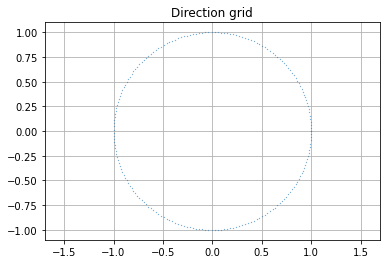

In [2]:
# Directions for support function / element
angle_range = np.linspace(0, 2*np.pi, 200)
p_range = np.array([np.cos(angle_range), np.sin(angle_range)]).T

fig, ax = plt.subplots()
ax.set_title('Direction grid')
ax.axis('equal')
ax.grid()
ax.plot(*p_range.T, '.', markersize=0.5);

## Example 1: Jordan block (two equal real eigenvalues)

$$\dot{x} = A x + B u$$

$$A = \begin{bmatrix} 
-\sigma & 1 \\
0 & -\sigma
\end{bmatrix}, \sigma > 0$$
$$e^{At} = e^{-\sigma t} \begin{bmatrix} 
1 & t \\
0 & 1
\end{bmatrix}$$

Case 1, 2D control, ball-bounded:

$$B = \begin{bmatrix} 1 & 0\\ 0 & 1 \end{bmatrix}, \quad u \in U = \{u : \|u\|_2 \leq 1\}$$
$$s_U(q) = \|q\|_2, \quad a_U(q) = \frac{q}{\|q\|}, q \neq 0$$

Case 2, scalar control:

$$B = \begin{bmatrix} 0 \\ 1 \end{bmatrix}, \quad 
u \in U = \{u : |u| \leq 1\}$$
$$s_U(q) = |q|, \quad a_U(q) = \textrm{sign}\,(q)$$

For the latter case example of optimal control is presented.

In [3]:
print('Try different decay rate and run time.')

T = 6
sigma = 0.3

A_1 = np.array([
    [-sigma, 1], 
    [0, -sigma]
])
def expm_2equal(t, sigma=1):
    """Matrix exponential exp(A t) of 2x2 Jordan block with given eigenvalue -sigma. Andrey Tremba"""
    return np.exp(-sigma * t) * np.array([[1, t], [0, 1]])

exp_func_A_1 = lambda t : expm_2equal(t, sigma)

np.testing.assert_allclose(sc.linalg.expm(A_1 * T), exp_func_A_1(T)) # fast check

print(f'Problem setup: matrix exponential for sigma = {sigma} is ready.\nT = {T}')

Try different decay rate and run time.
Problem setup: matrix exponential for sigma = 0.3 is ready.
T = 6


Support set for 2D ball-bounded control.


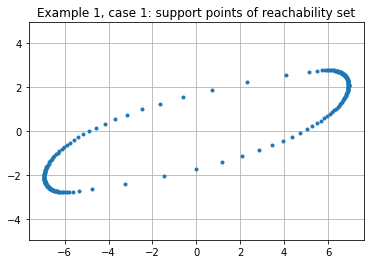

In [4]:
print('Support set for 2D ball-bounded control.')

sup_func_u_ball = lambda q : q / np.sqrt(sum(q**2))

reachability_support_u_ball = lambda p, T : \
    reach_set.get_reachability_set_support(p, T, exp_func_A_1, sup_func_u_ball)

support_elements = np.array([reachability_support_u_ball(p, T) for p in p_range])

fig, ax = plt.subplots()
ax.set_title('Example 1, case 1: support points of reachability set')
ax.axis('equal')
ax.grid()
ax.plot(*support_elements.T, '.');

Support set for scalar control.


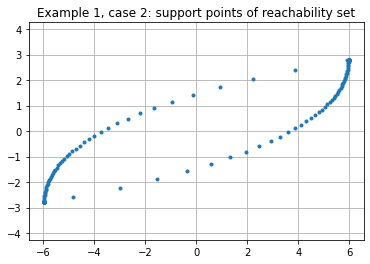

In [5]:
print('Support set for scalar control.')

sup_func_u_segment = lambda q : np.sign(q)
B_segment = np.array([0, 1])

reachability_support_u_segment = lambda p, T : \
    reach_set.get_reachability_set_support(p, T, exp_func_A_1, sup_func_u_segment, B_segment)

support_elements = np.array([reachability_support_u_segment(p, T) for p in p_range])

fig, ax = plt.subplots()
ax.set_title('Example 1, case 2: support points of reachability set')
ax.axis('equal')
ax.grid()
ax.plot(*support_elements.T, '.');

A trajectory and optimal control
p = array([-0.26515648,  0.96420539])
Numerical integration with optimal control
Residual between support element and final point, calculated numerically: 0.007311516268082349


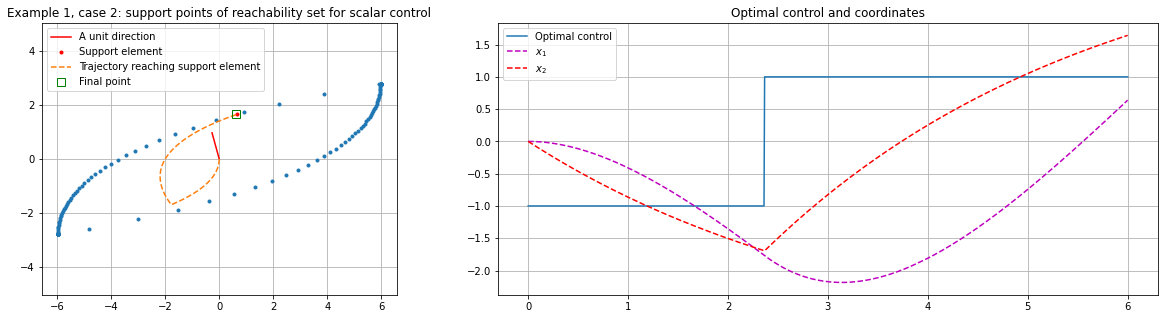

In [6]:
print('A trajectory and optimal control')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw={'width_ratios': [7, 13]})
ax1.set_title('Example 1, case 2: support points of reachability set for scalar control')
ax1.axis('equal')
ax1.grid()
ax1.plot(*support_elements.T, '.');

ax2.set_title('Optimal control and coordinates')
ax2.grid()

# Get a support point for some direction
# np.random.default_rng(1)
# p = np.random.randn(2)
p = np.array([-0.55, 2])
p = p / np.linalg.norm(p)
ax1.plot([0, p[0]], [0, p[1]], 'r', label='A unit direction')
print(f'{p = }')
sup_element = reachability_support_u_segment(p, T)
ax1.plot(*sup_element, 'or', markersize=3, label='Support element')

u_opt_func = lambda t : reach_set.instant_universal_control_s(T - t, p, exp_func_A_1, sup_func_u_segment, B_segment)

t_range = np.linspace(0, T, 1000)

u_opt = [u_opt_func(t) for t in t_range]

ax2.plot(t_range, u_opt, label='Optimal control')

print('Numerical integration with optimal control')

rhs_with_explicit_control = lambda y, u : A_1 @ y + B_segment * u

fun_optimal = lambda t, y : rhs_with_explicit_control(y, u_opt_func(t))
# RK45 gives error in support element ~0.01, BDF ~ 0.002, LSODA ~ 5e-5, Radau ~ 3e-4
sol = sc.integrate.solve_ivp(fun_optimal, [0, T], np.zeros(2), t_eval=t_range, method='LSODA')
np.testing.assert_allclose(t_range, sol.t)

final_point = sol.y.T[-1]

print(f'Residual between support element and final point, '
      f'calculated numerically: {np.linalg.norm(final_point - sup_element)}')

[X1, X2] = sol.y
ax1.plot(X1, X2, '--', label='Trajectory reaching support element')
ax1.plot(*final_point, 'sg', markersize=8, markerfacecolor='none', label='Final point')

ax1.legend()

ax2.plot(t_range, X1, '--m', label='$x_1$')
ax2.plot(t_range, X2, '--r', label='$x_2$')
ax2.legend();

## Example 2: two real eigenvalues


$$\dot{x} = A x + \begin{bmatrix} 0 \\ 1 \end{bmatrix} u, \quad u \in U = \{u : |u| \leq 1\}$$

Convert $A$ to diagonal form 
$$
V^{-1} A V = \begin{bmatrix}
-\sigma_1 & 0 \\
0 & -\sigma_2
\end{bmatrix}, \quad
\sigma_1 > 0, \sigma_2 > 0
$$

$$
e^{A t} = V \begin{bmatrix}
e^{-\sigma_1 t} & 0 \\
0 & e^{-\sigma_2 t}
\end{bmatrix}
V^{-1}
$$

As the matrix is stable, limiting reachability set is also plotted (approximated by $T = 100$).

In [7]:
Ts_2 = [0.1, 0.3, 0.7, 1.5, 4, 100]

A_2 = np.array([
    [-0.5, 1],
    [-1, -3]
])

eigs, V = np.linalg.eig(A_2)

print(f'Eigenvalues of A_2: {eigs}')

print(f'Diagonalized A_2: \n{np.linalg.inv(V) @ A_2 @ V}')

def expm_2real(t, eigs, V):
    """Matrix exponential exp(A t) of 2x2 diagonalized matrix with real eigenvalues. Andrey Tremba"""
    return V @ np.diag(np.exp(eigs * t)) @ np.linalg.inv(V)
    
exp_func_A_2 = lambda t : expm_2real(t, eigs, V)
    
np.testing.assert_allclose(sc.linalg.expm(A_2 * Ts_2[0]), exp_func_A_2(Ts_2[0])) # fast check



Eigenvalues of A_2: [-1.  -2.5]
Diagonalized A_2: 
[[-1.00000000e+00 -1.11022302e-16]
 [ 2.22044605e-16 -2.50000000e+00]]


In [8]:
# calculation takes up to few minutes
reachability_support_u_segment_2 = lambda p, T : \
    reach_set.get_reachability_set_support(p, T, exp_func_A_2, sup_func_u_segment, B_segment)

support_elements_2_array = [np.array([reachability_support_u_segment_2(p, T) for p in p_range]) for T in Ts_2]

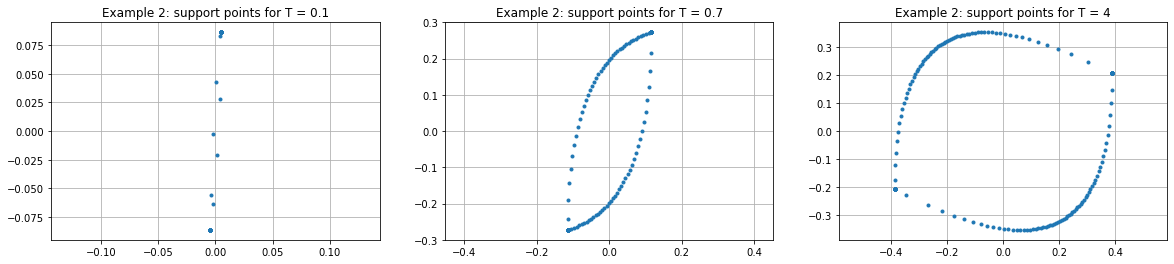

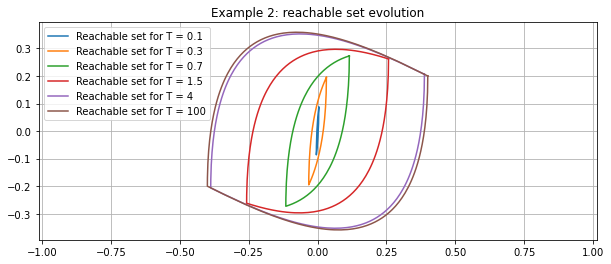

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
for k, ax in enumerate(axs):
    # plot support points for 0th, 2nd and 4th values of T
    ax.set_title(f'Example 2: support points for T = {Ts_2[2 * k]}')
    ax.axis('equal')
    ax.grid()
    ax.plot(*support_elements_2_array[2 * k].T, '.');
    
fig2, ax2 = plt.subplots(figsize=(10, 4))
ax2.set_title(f'Example 2: reachable set evolution')
ax2.axis('equal')
ax2.grid()
for k, T_2 in enumerate(Ts_2):
    ax2.plot(*support_elements_2_array[k].T, '-', markersize=2, label=f'Reachable set for T = {T_2}');

ax2.legend();